## Imports

In [1]:
!pip3 install openai==0.27.0 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 2.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import openai
from google.colab import userdata

import pandas as pd
pd.set_option('max_colwidth', 400)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import re
import time
import json
import matplotlib.pyplot as plt
import numpy as np

Mounted at /content/drive


In [ ]:
DATA_PATH = ""

FA = "2"
PROMPT_PATH = ""
RESULTS_PATH = ""

MERGED_DATA_PATH = ""

SEED = 312
N_BOOTSTRAP = 5000

In [ ]:
JUDGE_MODEL = "o3-2025-04-16"
openai.api_key = userdata.get("")

model_ids = [model.id for model in openai.Model.list().data]
assert JUDGE_MODEL in model_ids

## Data

In [ ]:
df = pd.read_csv(DATA_PATH)

df['Response'] = df['Response'].fillna('')
df = df.rename(columns={'XYZ ID':'student','Assessment ID':'assessment',\
                        'Conversation No.': 'turn','Role':'role','Response':'utterance'})
df = df.drop(columns=["Version"])
df = df[df['assessment'].isin([int(FA)])]
df = df.reset_index(drop=True)

assert not df.isnull().values.any()
assert df['student'].dtype == 'object'
assert df['student'].apply(lambda x: bool(re.fullmatch(r'XYZ25\d{3}', str(x)))).all()
assert df['assessment'].dtype == int
assert set(df['assessment'].unique()) == {int(FA)}
assert df['turn'].dtype == int
assert df['role'].dtype == 'object'
assert set(df['role'])=={'assistant','user','system'}
assert df['utterance'].dtype == 'object'

df.head()

In [ ]:
df['group'] = (df['turn'] == 0).cumsum()
convos = [group_df.drop(columns='group') for _, group_df in df.groupby('group')]

convos[0].head()

In [ ]:
for convo in convos:
  assert df['student'].dtype == 'object'
  assert len(set(convo["student"])) == 1
  assert convo['student'].apply(lambda x: bool(re.fullmatch(r'XYZ25\d{3}', str(x)))).all()

  assert df['assessment'].dtype == int
  assert len(set(convo["assessment"])) == 1
  assert convo["assessment"].iloc[0] in {int(FA)}

  assert df['turn'].dtype == int
  assert list(convo["turn"]) == list(range(len(convo)))

  assert df['role'].dtype == 'object'
  assert all(role in {"system", "user", "assistant"} for role in convo["role"])
  assert convo["role"].iloc[0] == "system" and convo["role"].iloc[1] == "assistant"

  roles = convo["role"].iloc[2:]
  expected_roles = ["user" if i%2 == 0 else "assistant" for i in range(len(roles))]
  assert list(roles) == expected_roles

  assert df['utterance'].dtype == 'object'

In [ ]:
print("Total conversations:",len(convos))
print("Total utterances:",len(df))
print("Total of student utterances:", (df["role"] == "user").sum())
print("Total of agent utterances:", (df["role"] == "assistant").sum())

Total conversations: 97
Total utterances: 2518
Total of student utterances: 1162
Total of agent utterances: 1259


## Prompt

In [ ]:
with open(PROMPT_PATH, 'r', encoding='utf-8') as f:
    prompt = f.read()

prompt

'You are a learning science researcher whose job it is to determine if a pedagogical agent\'s feedback to students correctly addresses students\' off-task behavior by nudging them to get back on task.\n\nPreviously, students were asked the following formative assessment question:\n\n"Write down each rule (recall the IF and THEN multiple choice from today for each category of rainfall)."\n\nThese are the three rules the students were required to identify (i.e., the correct formative assessment answer) :\n1. If rainfall is less than absorption limit, set absorption to rainfall and set runoff to 0.\n2. If rainfall is equal to absorption limit, set absorption to either rainfall or absorption limit, and set runoff to 0.\n3. If rainfall is greater than absorption limit, set absorption to absorption limit and set runoff to either rainfall - absorption limit or rainfall - absorption.\n\nStudents were graded on a 9-point rubric (1 point for each conditional statement, 1 point for setting the ab

## API Call

In [ ]:
def get_openai_response(messages):
  start_time = time.time()
  response = openai.ChatCompletion.create(
      model=JUDGE_MODEL,
      messages=messages,
      response_format={ "type": "json_object" },
      seed=SEED
  )

  total_time = time.time()-start_time
  total_tokens = response["usage"]["total_tokens"]
  generation = response["choices"][0]["message"]["content"].strip()

  return generation, total_time, total_tokens

In [ ]:
response = get_openai_response([{"role":"system","content":"Confirm that the api is working. Respond using the following JSON schema: {'working':bool, 'explanation':str}"}])
print(response)

('{"working": true, "explanation": "The API call was successfully received and a valid response has been generated."}', 3.719592332839966, 138)


## Generations

In [ ]:
results = [["student","assessment","conversation","turn","conversational_context", \
            "agent_utterance","generation","total_time_s","total_tokens", \
            "on_task_evidence", "on_task_score",
          ]]

for i,convo in enumerate(convos):
    if len(convo) < 4: continue
    conversational_context = "[CONVERSATIONAL_CONTEXT]"

    for j in range(3, len(convo), 2):
        # # Uncomment during testing to ensure veracity of roles as conversation context builds
        # assert convo.iloc[j]['role']=="assistant"
        # assert convo.iloc[j-1]['role']=="user"
        # assert convo.iloc[j-2]['role']=="assistant"

        prev_agent_utterance = convo.iloc[j-2]['utterance']
        prev_student_utterance = convo.iloc[j-1]['utterance']
        conversational_context += f"\n[AGENT]: {prev_agent_utterance}\n[STUDENT]: {prev_student_utterance}"
        curr_agent_utterance = "[MOST_RECENT_AGENT_UTTERANCE]\n" + convo.iloc[j]['utterance']

        user_str = f"{conversational_context}\n\n\n{curr_agent_utterance}"
        messages = [{"role":"system","content":prompt},{"role":"user","content":user_str}]

        successfully_finished, attempts_remaining = False, 3
        while not successfully_finished and attempts_remaining>0:
            try:
                generation, total_time, total_tokens = get_openai_response(messages)
                parsed_generation = json.loads(generation)

                on_task_evidence = parsed_generation["explanation"]
                on_task_score = parsed_generation["on_task_score"]

                conversational_context = conversational_context
                curr_agent_utterance = curr_agent_utterance

                results.append([
                    convo.iloc[j]['student'],
                    convo.iloc[j]['assessment'],
                    i,
                    convo.iloc[j]['turn'],
                    conversational_context,
                    curr_agent_utterance,
                    generation,
                    round(total_time, 1),
                    total_tokens,
                    on_task_evidence,
                    on_task_score
                ])
                successfully_finished = True
            except json.JSONDecodeError as e:
                print(f"Failed JSON parsing for conversation {i}, agent utterance {j}: {e}")
                attempts_remaining -= 1
                time.sleep(3)
                continue
            except openai.error.RateLimitError as e:
                print(f"Failed API rate limit convo {i}, agent {j}: {e}")
                attempts_remaining -= 1
                time.sleep(3)
                continue
            except Exception as e:
                print(f"Failed api call for conversation {i}, agent utterance {j}: {e}")
                attempts_remaining -= 1
                time.sleep(3)
                continue

        if not successfully_finished:
            print(f"\n\nGave up after 3 attempts on convo {i}, agent {j}\n\n")

        print(f"Finished conversation {i}, utterance {j}")
    print(f"\n\nFinished conversation {i}\n\n")

Finished conversation 0, utterance 3
Finished conversation 0, utterance 5
Finished conversation 0, utterance 7
Finished conversation 0, utterance 9
Finished conversation 0, utterance 11
Finished conversation 0, utterance 13
Finished conversation 0, utterance 15
Finished conversation 0, utterance 17
Finished conversation 0, utterance 19
Finished conversation 0, utterance 21
Finished conversation 0, utterance 23
Finished conversation 0, utterance 25
Finished conversation 0, utterance 27
Finished conversation 0, utterance 29
Finished conversation 0, utterance 31
Finished conversation 0, utterance 33
Finished conversation 0, utterance 35
Finished conversation 0, utterance 37
Finished conversation 0, utterance 39
Finished conversation 0, utterance 41
Finished conversation 0, utterance 43


Finished conversation 0


Finished conversation 1, utterance 3
Finished conversation 1, utterance 5
Finished conversation 1, utterance 7
Finished conversation 1, utterance 9
Finished conversation 1, utter

## Save

In [ ]:
df_results = pd.DataFrame(results[1:], columns=results[0])
assert not df_results.isnull().values.any()
df_results.to_csv(RESULTS_PATH, index=False)

## EDA

In [ ]:
df_results = pd.read_csv(MERGED_DATA_PATH)
df_results = df_results[df_results["assessment"]==int(FA)]
df_results.head()

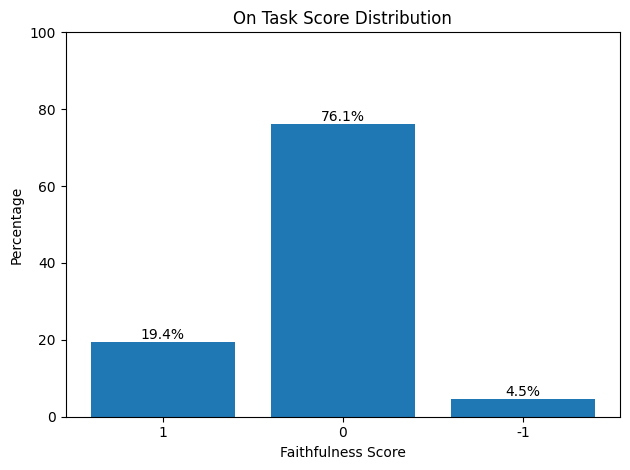

In [6]:
score_col = "on_task_score"

pct = (
    df_results[score_col]
    .value_counts(normalize=True)
    .reindex([1, 0, -1], fill_value=0)
    .mul(100)
)


plt.figure()
bars = plt.bar(pct.index.astype(str), pct.values)
plt.title(f"{score_col.replace('_', ' ').title()} Distribution")
plt.xlabel("Faithfulness Score")
plt.ylabel("Percentage")


for bar, value in zip(bars, pct.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.1f}%",
        ha="center",
        va="bottom",
    )

plt.ylim(0, 100)
plt.tight_layout()

## Confidence Intervals

In [7]:
boot_on_task  = []
boot_off_task = []

values = df_results["on_task_score"].to_numpy()

rng = np.random.default_rng(seed=SEED)

for _ in range(N_BOOTSTRAP):
    resample = rng.choice(values, size=len(df_results), replace=True)
    boot_on_task.append((resample ==  1).mean())
    boot_off_task.append((resample == -1).mean())

on_task_low,  on_task_high  = np.percentile(boot_on_task,   [2.5, 97.5])
off_task_low, off_task_high = np.percentile(boot_off_task, [2.5, 97.5])

win_moe  = (on_task_high-on_task_low) / 2
loss_moe = (off_task_high-off_task_low) / 2

p_cons   = (values ==  1).mean()
p_incons = (values == -1).mean()

print(f"On task (1):    {p_cons*100:.2f} ± {win_moe*100:.2f}  (95 % CI)")
print(f"Off task (-1): {p_incons*100:.2f} ± {loss_moe*100:.2f}  (95 % CI)")

On task (1):    19.43 ± 2.25  (95 % CI)
Off task (-1): 4.49 ± 1.17  (95 % CI)
